# Metrics, validation strategies and baselines

В данном jupyter notebook рассматриваются примеры того, какие схемы валидации и метрики используются в рекомендательных системах.
Также построим простые модели (бейзлайны) на данных МТС Библиотеки. 

* [Preprocessing](#preprocessing)
* [General remarks](#general-remarks)
* [Metrics](#metrics)
    * [Regression](#regression)
    * [Classification](#classification)
    * [Ranking](#ranking)
* [Validation strategies](#validation)
* [Baselines](#baselines)

In [1]:
import os
import numpy as np 
import pandas as pd 
from itertools import islice, cycle
from more_itertools import pairwise

print('Dataset:')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Dataset:
/kaggle/input/mts-library/items.csv
/kaggle/input/mts-library/interactions.csv
/kaggle/input/mts-library/users.csv


<a id="preprocessing"></a>
# Preprocessing

Загрузим наши данные, теперь уже с фичами, и применим знания из [pandas-scipy-for-recsys](https://www.kaggle.com/sharthz23/pandas-scipy-for-recsys)

In [2]:
df = pd.read_csv('../input/mts-library/interactions.csv')
df_users = pd.read_csv('../input/mts-library/users.csv')
df_items = pd.read_csv('../input/mts-library/items.csv')

## Interactions

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1533078 entries, 0 to 1533077
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   user_id     1533078 non-null  int64  
 1   item_id     1533078 non-null  int64  
 2   progress    1533078 non-null  int64  
 3   rating      285356 non-null   float64
 4   start_date  1533078 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 58.5+ MB


In [4]:
df['start_date'] = pd.to_datetime(df['start_date'])

In [5]:
duplicates = df.duplicated(subset=['user_id', 'item_id'], keep=False)
df_duplicates = df[duplicates].sort_values(by=['user_id', 'start_date'])
df = df[~duplicates]

In [6]:
df_duplicates = df_duplicates.groupby(['user_id', 'item_id']).agg({
    'progress': 'max',
    'rating': 'max',
    'start_date': 'min'
})
df = df.append(df_duplicates.reset_index(), ignore_index=True)

In [7]:
df['progress'] = df['progress'].astype(np.int8)
df['rating'] = df['rating'].astype(pd.SparseDtype(np.float32, np.nan))

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1532998 entries, 0 to 1532997
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype               
---  ------      --------------    -----               
 0   user_id     1532998 non-null  int64               
 1   item_id     1532998 non-null  int64               
 2   progress    1532998 non-null  int8                
 3   rating      285355 non-null   Sparse[float32, nan]
 4   start_date  1532998 non-null  datetime64[ns]      
dtypes: Sparse[float32, nan](1), datetime64[ns](1), int64(2), int8(1)
memory usage: 38.7 MB


In [9]:
df.to_pickle('interactions_preprocessed.pickle')

In [10]:
!ls -lah

total 39M
drwxr-xr-x 2 root root 4.0K Oct 25 07:01 .
drwxr-xr-x 6 root root 4.0K Oct 25 07:01 ..
---------- 1 root root 267K Oct 25 07:01 __notebook__.ipynb
-rw-r--r-- 1 root root  39M Oct 25 07:01 interactions_preprocessed.pickle


## Users

In [11]:
df_users.head()

user_id     age  sex
0        1   45_54  NaN
1        2   18_24  0.0
2        3  65_inf  0.0
3        4   18_24  0.0
4        5   35_44  0.0

In [12]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142888 entries, 0 to 142887
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  142888 non-null  int64  
 1   age      142742 non-null  object 
 2   sex      136626 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.3+ MB


In [13]:
df_users.nunique()

user_id    142888
age             6
sex             2
dtype: int64

In [14]:
df_users['age'] = df_users['age'].astype('category')
df_users['sex'] = df_users['sex'].astype(pd.SparseDtype(np.float32, np.nan))

In [15]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142888 entries, 0 to 142887
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype               
---  ------   --------------   -----               
 0   user_id  142888 non-null  int64               
 1   age      142742 non-null  category            
 2   sex      136626 non-null  Sparse[float32, nan]
dtypes: Sparse[float32, nan](1), category(1), int64(1)
memory usage: 2.3 MB


In [16]:
interaction_users = df['user_id'].unique()

common_users = len(np.intersect1d(interaction_users, df_users['user_id']))
users_only_in_interaction = len(np.setdiff1d(interaction_users, df_users['user_id']))
users_only_features = len(np.setdiff1d(df_users['user_id'], interaction_users))
total_users = common_users + users_only_in_interaction + users_only_features
print(f'Кол-во пользователей - {total_users}')
print(f'Кол-во пользователей c взаимодействиями и фичами - {common_users} ({common_users / total_users * 100:.2f}%)')
print(f'Кол-во пользователей только c взаимодействиями - {users_only_in_interaction} ({users_only_in_interaction / total_users * 100:.2f}%)')
print(f'Кол-во пользователей только c фичами - {users_only_features} ({users_only_features / total_users * 100:.2f}%)')

Кол-во пользователей - 158811
Кол-во пользователей c взаимодействиями и фичами - 135677 (85.43%)
Кол-во пользователей только c взаимодействиями - 15923 (10.03%)
Кол-во пользователей только c фичами - 7211 (4.54%)


In [17]:
df_users.to_pickle('users_preprocessed.pickle')

In [18]:
!ls -lah

total 42M
drwxr-xr-x 2 root root 4.0K Oct 25 07:01 .
drwxr-xr-x 6 root root 4.0K Oct 25 07:01 ..
---------- 1 root root 274K Oct 25 07:01 __notebook__.ipynb
-rw-r--r-- 1 root root  39M Oct 25 07:01 interactions_preprocessed.pickle
-rw-r--r-- 1 root root 2.3M Oct 25 07:01 users_preprocessed.pickle


## Items

In [19]:
df_items.head()

id              title  \
0  128115   Ворон-челобитчик   
1  210979  Скрипка Ротшильда   
2   95632   Испорченные дети   
3  247906   Странный человек   
4  294280  Господа ташкентцы   

                                              genres                 authors  \
0  Зарубежные детские книги,Сказки,Зарубежная кла...  Михаил Салтыков-Щедрин   
1  Классическая проза,Литература 19 века,Русская ...             Антон Чехов   
2  Зарубежная классика,Классическая проза,Литерат...  Михаил Салтыков-Щедрин   
3             Пьесы и драматургия,Литература 19 века        Михаил Лермонтов   
4  Зарубежная классика,Классическая проза,Литерат...  Михаил Салтыков-Щедрин   

   year  
0  1886  
1  1894  
2  1869  
3  1831  
4  1873

In [20]:
df_items.info(memory_usage='full')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59599 entries, 0 to 59598
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       59599 non-null  int64 
 1   title    59599 non-null  object
 2   genres   59568 non-null  object
 3   authors  52714 non-null  object
 4   year     46720 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.3+ MB


In [21]:
def num_bytes_format(num_bytes, float_prec=4):
    units = ['bytes', 'Kb', 'Mb', 'Gb', 'Tb', 'Pb', 'Eb']
    for unit in units[:-1]:
        if abs(num_bytes) < 1000:
            return f'{num_bytes:.{float_prec}f} {unit}'
        num_bytes /= 1000
    return f'{num_bytes:.4f} {units[-1]}'

In [22]:
num_bytes = df_items.memory_usage(deep=True).sum()
num_bytes_format(num_bytes)

'28.1660 Mb'

In [23]:
df_items.nunique()

id         59599
title      57358
genres     10769
authors    17265
year        1053
dtype: int64

Почему колонка `year` типа `object`, а не `int`?

In [24]:
df_items['year'].value_counts().tail(25)

1962,1970                       1
1947, 1957, 1958, 1969, 2005    1
1930, 1925                      1
1805                            1
1608,1623                       1
1000                            1
до 1837 г.                      1
1670                            1
2001, 2005, 2008, 2015, 2017    1
1999-2017                       1
2000,2019                       1
1895–1900                       1
1945-1946                       1
2003, 2004, 2007                1
1350                            1
1931, 1929, 1942                1
1914-1919                       1
1936, 1947                      1
1968, 1979                      1
1852-1856                       1
1887,1902                       1
1977, 1995                      1
2014–2019                       1
450–399 г. до н.э.              1
1932-1936                       1
Name: year, dtype: int64

In [25]:
df_items[df_items['year'] == '1898, 1897, 1901']

id                                              title  \
44131  273885  «Мальчик, который рисовал кошек» и другие исто...   

                                                  genres        authors  \
44131  Ужасы,Мистика,Зарубежная классика,Литература 1...  Лафкадио Хирн   

                   year  
44131  1898, 1897, 1901

In [26]:
for col in ['genres', 'authors', 'year']:
    df_items[col] = df_items[col].astype('category')

In [27]:
df_items.info(memory_usage='full')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59599 entries, 0 to 59598
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   id       59599 non-null  int64   
 1   title    59599 non-null  object  
 2   genres   59568 non-null  category
 3   authors  52714 non-null  category
 4   year     46720 non-null  category
dtypes: category(3), int64(1), object(1)
memory usage: 2.4+ MB


In [28]:
num_bytes = df_items.memory_usage(deep=True).sum()
num_bytes_format(num_bytes)

'17.9177 Mb'

In [29]:
interaction_items = df['item_id'].unique()

common_items = len(np.intersect1d(interaction_items, df_items['id']))
items_only_in_interaction = len(np.setdiff1d(interaction_items, df_items['id']))
items_only_features = len(np.setdiff1d(df_items['id'], interaction_items))
total_items = common_items + items_only_in_interaction + items_only_features
print(f'Кол-во книг - {total_items}')
print(f'Кол-во книг c взаимодействиями и фичами - {common_items} ({common_items / total_items * 100:.2f}%)')
print(f'Кол-во книг только c взаимодействиями - {items_only_in_interaction} ({items_only_in_interaction / total_items * 100:.2f}%)')
print(f'Кол-во книг только c фичами - {items_only_features} ({items_only_features / total_items * 100:.2f}%)')

Кол-во книг - 59599
Кол-во книг c взаимодействиями и фичами - 59599 (100.00%)
Кол-во книг только c взаимодействиями - 0 (0.00%)
Кол-во книг только c фичами - 0 (0.00%)


In [30]:
df_items.to_pickle('items_preprocessed.pickle')

In [31]:
!ls -lah

total 48M
drwxr-xr-x 2 root root 4.0K Oct 25 07:01 .
drwxr-xr-x 6 root root 4.0K Oct 25 07:01 ..
---------- 1 root root 288K Oct 25 07:01 __notebook__.ipynb
-rw-r--r-- 1 root root  39M Oct 25 07:01 interactions_preprocessed.pickle
-rw-r--r-- 1 root root 6.0M Oct 25 07:01 items_preprocessed.pickle
-rw-r--r-- 1 root root 2.3M Oct 25 07:01 users_preprocessed.pickle


<a id="general-marks"></a>
# General marks

Основная цель валидации - оценить качество модели перед внедрением в "продакшен" или сабмитом в соревновании. Отсюда вытекает одно из самых важных требование к процессу валидации - *схема должна максимально точно воспроизводить условия, в которых модель будет использоваться.* Это касается как продакшена, так и соревнований, причем не только в рекомендательных системах, а в любой задаче машинного обучения. **Правильная валидация - ключ к успеху** :)

Ключевые вопросы, на которые надо ответить:
* Что хотим от модели?
    * Предсказанное значение для пары пользователь-объект (рейтинг или вероятность)
    * Ранжирование объектов для пользователя (топ фильмов)
* Как будет использоваться модель? 
    * Рекомендации будут считаться батчами раз в период (1 раз в день)
    * Онлайн-рекомендации
    * Связь бизнес-метрик с оффлайн-метриками
* Какие технические ограничения?
    * По времени построения как системы в целом, так и отдельных рекомендаций (чем меньше "железа", тем проще должна быть модель)
    * Какие данные будут доступны в онлайн-режиме
* Как есть особенности у задачи?
    * Рекомендуем ли для пользователя объекты, с которым он уже взаимодействовал (для фильмов или книг - скорее всего нет, для продуктового ритейла - может быть и да)
    * Cold-start - как много появится пользователей или объектов, для которых не известная история по взаимодействиям
    * Как много взаимодействий по пользователям есть в данных

<a id="metrics"></a>
# Metrics

Как это водится в машинном обучении, для подсчета метрик нам нужно два массива: правильный ответы и предсказанные ответы.
И если в классическом машинном обучении это действительно два массива, то в рекомендательных системах нам нужна структура, которая в качевстве ключа или индекса будет содержать пары пользователь-объект.

В качестве такой структуры вполне подойдет уже известный pandas.DataFrame. 
Правильные метки (true) мы можем представить в виде dataframe со следующими столбцами:
* user_id - ID пользователя
* item_id - ID объекта
* value - оценка взаимодействия (опционально, может и не быть, если мы, например, за взаимодействие берем просто клик или факт покупки)

Соответственно, рекомендации/предсказания (recs) в следующем:
* user_id - ID пользователя
* item_id - ID объекта
* value - предсказанная оценка взаимодействия 
    * Численная оценка, например рейтинг
    * Позиция, если мы ранжируем контент
    
Для подсчета метрик мы можем объединить эти два датафрема по `(user_id, item_id)`. В качестве метода объединения можно использовать методы join/merge из pandas.DataFrame.

<a id="regression"></a>
## Regression

Эти метрики оценивают качество предсказанных численных оценок. Примеры метрик:
* Mean Squared Error - среднеквадратичная ошибка
* Root Mean Squared Error - корень из среднеквадратичной ошибки
* Mean Absolute Error - средний ошибка по модулю
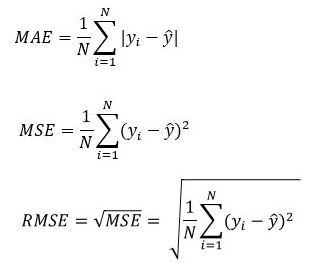
Эти метрики показываются, как хорошо модель "восстанавливает" какие-то численные оценки, но не то, насколько хороши рекомендации

In [32]:
df_true = pd.DataFrame({
    'user_id': ['Аня',                'Боря',               'Вася',         'Вася'],
    'item_id': ['Мастер и Маргарита', '451° по Фаренгейту', 'Зеленая миля', 'Рита Хейуорт и спасение из Шоушенка'],
    'value':   [4,                    5,                    3,            5]
})
df_true

user_id                              item_id  value
0     Аня                   Мастер и Маргарита      4
1    Боря                   451° по Фаренгейту      5
2    Вася                         Зеленая миля      3
3    Вася  Рита Хейуорт и спасение из Шоушенка      5

In [33]:
df_recs = pd.DataFrame({
    'user_id': ['Аня',                'Боря',               'Вася',         'Вася'],
    'item_id': ['Мастер и Маргарита', '451° по Фаренгейту', 'Зеленая миля', 'Рита Хейуорт и спасение из Шоушенка'],
    'value':   [3.28,                 3.5,                  4.06,           4.73]
})
df_recs

user_id                              item_id  value
0     Аня                   Мастер и Маргарита   3.28
1    Боря                   451° по Фаренгейту   3.50
2    Вася                         Зеленая миля   4.06
3    Вася  Рита Хейуорт и спасение из Шоушенка   4.73

In [34]:
df_true = df_true.set_index(['user_id', 'item_id'])
df_recs = df_recs.set_index(['user_id', 'item_id'])

df_merged = df_true.join(df_recs, how='left', lsuffix='_true', rsuffix='_recs')
df_merged

value_true  value_recs
user_id item_id                                                    
Аня     Мастер и Маргарита                            4        3.28
Боря    451° по Фаренгейту                            5        3.50
Вася    Зеленая миля                                  3        4.06
        Рита Хейуорт и спасение из Шоушенка           5        4.73

In [35]:
df_merged['MAE'] = (df_merged['value_true'] - df_merged['value_recs']).abs()
df_merged['MSE'] = (df_merged['value_true'] - df_merged['value_recs']) ** 2
df_merged

value_true  value_recs   MAE  \
user_id item_id                                                             
Аня     Мастер и Маргарита                            4        3.28  0.72   
Боря    451° по Фаренгейту                            5        3.50  1.50   
Вася    Зеленая миля                                  3        4.06  1.06   
        Рита Хейуорт и спасение из Шоушенка           5        4.73  0.27   

                                                MSE  
user_id item_id                                      
Аня     Мастер и Маргарита                   0.5184  
Боря    451° по Фаренгейту                   2.2500  
Вася    Зеленая миля                         1.1236  
        Рита Хейуорт и спасение из Шоушенка  0.0729

In [36]:
print(f"MAE  - {df_merged['MAE'].mean():.4f}")
print(f"MSE  - {df_merged['MSE'].mean():.4f}")
print(f"RMSE - {np.sqrt(df_merged['MSE'].mean()):.4f}")

MAE  - 0.8875
MSE  - 0.9912
RMSE - 0.9956


<a id="classification"></a>
## Classification

Эти метрики оценивают качество топ-N рекомендаций. В рекомендательные системы напрямую перекочевали из методов оценки качества бинарной классификации.
Все считается на основе 4 базовых случаев:
* True positive  (TP) - модель рекомендовала объект, с которым пользователь провзаимодействовал
* False positive (FP) - модель рекомендовала объект, с которым пользователь не провзаимодействовал
* True negative  (TN) - модель не рекомендовала объект, с которым пользователь не провзаимодействовал
* False negative (FN) - модель не рекомендовала объект, с которым пользователь провзаимодействовал

Что из этого всего важней? В первую очередь это True positive. Мы хотим строить наиболее релевантные рекомендации для пользователя. 
Во вторую очередь это False negative, опять же потому, что мы не хотим, чтобы модель "теряла" релевантные рекомендации.

А что с FP и TN? На самом деле, эти величины не показательны. Они обычно очень больше, так как пользователи взаимодействуют с очень малым количество объектов относительно общего числа объектов.
И практика показывает, что этими значениями можно пренебречь.

Для измерения доли TP и FN применяются следующие метрики:
* **Precision@K** - доля релевантных рекомендаций среди всех рекомендаций
    * Формула - `TP / (TP + FP)`
    * Можно заметить, что под positives мы понимаем рекомендованные объекты, то есть наш топ-К, значит `TP + FP = K`
    * Итоговая формула - `TP / K`
    * Считаем по каждому пользователю и для некторых К
    * Усредняем по всем пользователя
* **Recall@K** - доля релевантных рекомендаций среди всех релевантных объектов
    * Формула - `TP / (TP + FN)`
    * `TP + FN` это количество известных релевантых объектов для пользователя
    * Считаем по каждому пользователю и для некторых К
    * Усредняем по всем пользователя

Это основные метрики, но на основе TP, FP, TN, FN можно посчитать все что угодно :)
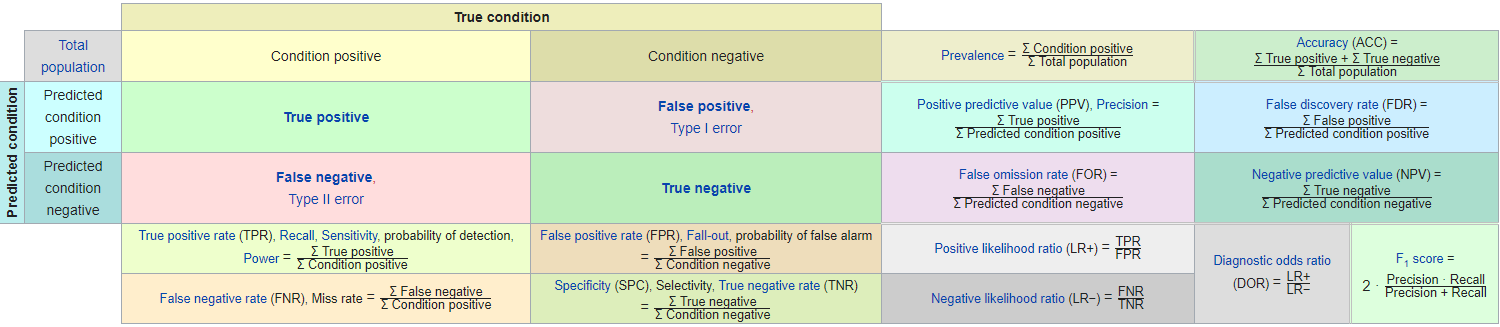
Источник - [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

In [37]:
df_true = pd.DataFrame({
    'user_id': ['Аня',                'Боря',               'Вася',         'Вася'],
    'item_id': ['Мастер и Маргарита', '451° по Фаренгейту', 'Зеленая миля', 'Рита Хейуорт и спасение из Шоушенка'],
})
df_true

user_id                              item_id
0     Аня                   Мастер и Маргарита
1    Боря                   451° по Фаренгейту
2    Вася                         Зеленая миля
3    Вася  Рита Хейуорт и спасение из Шоушенка

In [38]:
df_recs = pd.DataFrame({
    'user_id': [
        'Аня', 'Аня', 'Аня', 
        'Боря', 'Боря', 'Боря', 
        'Вася', 'Вася', 'Вася',
    ],
    'item_id': [
        'Отверженные', 'Двенадцать стульев', 'Герои нашего времени', 
        '451° по Фаренгейту', '1984', 'О дивный новый мир',
        'Десять негритят', 'Искра жизни', 'Зеленая миля', 
    ],
    'rank': [
        1, 2, 3,
        1, 2, 3,
        1, 2, 3,
    ]
})
df_recs

user_id               item_id  rank
0     Аня           Отверженные     1
1     Аня    Двенадцать стульев     2
2     Аня  Герои нашего времени     3
3    Боря    451° по Фаренгейту     1
4    Боря                  1984     2
5    Боря    О дивный новый мир     3
6    Вася       Десять негритят     1
7    Вася           Искра жизни     2
8    Вася          Зеленая миля     3

In [39]:
df_merged = df_true.set_index(['user_id', 'item_id']).join(df_recs.set_index(['user_id', 'item_id']), how='left')
df_merged

rank
user_id item_id                                  
Аня     Мастер и Маргарита                    NaN
Боря    451° по Фаренгейту                    1.0
Вася    Зеленая миля                          3.0
        Рита Хейуорт и спасение из Шоушенка   NaN

Вначале посчитаем метрик для топ-2 (т.е. К = 2). Алгоритм следующий:
* Релевантные объекты, которые не были рекомендованы игнорируем (NaN)
* Определяем, какие релеватные рекомендации попали в топ-2 (hit)
    * True positive для каждого пользователя
* Делим TP на K  
* Считаем Precision@K для каждого пользователя как сумму его TP/K
* Все Precision@K усредняем

In [40]:
df_merged['hit@2'] = df_merged['rank'] <= 2
df_merged

rank  hit@2
user_id item_id                                         
Аня     Мастер и Маргарита                    NaN  False
Боря    451° по Фаренгейту                    1.0   True
Вася    Зеленая миля                          3.0  False
        Рита Хейуорт и спасение из Шоушенка   NaN  False

In [41]:
df_merged['hit@2/2'] = df_merged['hit@2'] / 2
df_merged

rank  hit@2  hit@2/2
user_id item_id                                                  
Аня     Мастер и Маргарита                    NaN  False      0.0
Боря    451° по Фаренгейту                    1.0   True      0.5
Вася    Зеленая миля                          3.0  False      0.0
        Рита Хейуорт и спасение из Шоушенка   NaN  False      0.0

In [42]:
df_prec2 = df_merged.groupby(level=0)['hit@2/2'].sum()
df_prec2

user_id
Аня     0.0
Боря    0.5
Вася    0.0
Name: hit@2/2, dtype: float64

In [43]:
print(f'Precision@2 - {df_prec2.mean()}')

Precision@2 - 0.16666666666666666


Но вообще шаг с группировкой по пользователям для Precision@K не нужен

In [44]:
df_merged['hit@2/2'].sum() / df_merged.index.get_level_values('user_id').nunique()

0.16666666666666666

In [45]:
users_count = df_merged.index.get_level_values('user_id').nunique()
for k in [1, 2, 3]:
    hit_k = f'hit@{k}'
    df_merged[hit_k] = df_merged['rank'] <= k
    print(f'Precision@{k} = {(df_merged[hit_k] / k).sum() / users_count:.4f}')

Precision@1 = 0.3333
Precision@2 = 0.1667
Precision@3 = 0.2222


C Recall@K похожая история, нам также нужно получить hit@K, но делить уже будем на количество релевантных объектов у пользователя

In [46]:
df_merged['users_item_count'] = df_merged.groupby(level='user_id')['rank'].transform(np.size)
df_merged

rank  hit@2  hit@2/2  hit@1  \
user_id item_id                                                            
Аня     Мастер и Маргарита                    NaN  False      0.0  False   
Боря    451° по Фаренгейту                    1.0   True      0.5   True   
Вася    Зеленая миля                          3.0  False      0.0  False   
        Рита Хейуорт и спасение из Шоушенка   NaN  False      0.0  False   

                                             hit@3  users_item_count  
user_id item_id                                                       
Аня     Мастер и Маргарита                   False               1.0  
Боря    451° по Фаренгейту                    True               1.0  
Вася    Зеленая миля                          True               2.0  
        Рита Хейуорт и спасение из Шоушенка  False               2.0

In [47]:
for k in [1, 2, 3]:
    hit_k = f'hit@{k}'
    # Уже посчитано
    # df_merged[hit_k] = df_merged['rank'] <= k  
    print(f"Recall@{k} = {(df_merged[hit_k] / df_merged['users_item_count']).sum() / users_count:.4f}")

Recall@1 = 0.3333
Recall@2 = 0.3333
Recall@3 = 0.5000


Precision@K и Recall@K неплохие метрики, чтобы оценить качество рекомендаций, но они учитывают только "попадания" (hits, true positives). 
Но на самом деле нам важно насколько высоко по позициям находятся эти самые попадания. 

Простой пример, пусть две модели рекомендаций для одного пользователя получили такие hit@3 на тесте:
* model1 - 1, 0, 0, 1
* model2 - 1, 0, 1, 0

Precision@4 для них будет одинаковый - 0.5, хотя model2 немного лучше, так как 2-ое попадание находится выше, чем у model1

<a id="ranking"></a>
## Ranking

Эти метрики оценивают качество топ-N рекомендаций c учетом рангов/позиций. Основная идея - оценить "попадания" с весом, зависящим от позиции (обычно это обратная пропорциальная зависимость, то есть чем больше позиция, тем меньше вес).
Основные метрики следующие:

**Mean Reciprocal Rank**
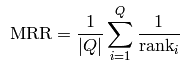
Где Q - это query или наш пользователь, а rank_i - позиция первой релевантной рекомендации

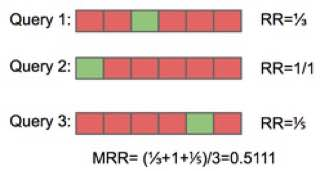

**Mean Average Precision**
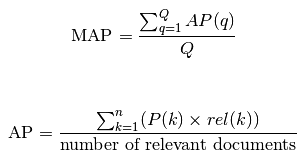
То есть MAP - это усреднение AveragePrecision по всем пользователям. 
А AveragePrecision в свою очередь, это средний Precision@K по релевантным объектам одного пользователя

In [48]:
df_true = pd.DataFrame({
    'user_id': ['Аня',                'Боря',               'Вася',         'Вася'],
    'item_id': ['Мастер и Маргарита', '451° по Фаренгейту', 'Зеленая миля', 'Рита Хейуорт и спасение из Шоушенка'],
})
df_true 

user_id                              item_id
0     Аня                   Мастер и Маргарита
1    Боря                   451° по Фаренгейту
2    Вася                         Зеленая миля
3    Вася  Рита Хейуорт и спасение из Шоушенка

In [49]:
df_recs = pd.DataFrame({
    'user_id': [
        'Аня', 'Аня', 'Аня', 
        'Боря', 'Боря', 'Боря', 
        'Вася', 'Вася', 'Вася',
    ],
    'item_id': [
        'Отверженные', 'Двенадцать стульев', 'Герои нашего времени', 
        '451° по Фаренгейту', '1984', 'О дивный новый мир',
        'Десять негритят', 'Рита Хейуорт и спасение из Шоушенка', 'Зеленая миля', 
    ],
    'rank': [
        1, 2, 3,
        1, 2, 3,
        1, 2, 3,
    ]
})
df_recs

user_id                              item_id  rank
0     Аня                          Отверженные     1
1     Аня                   Двенадцать стульев     2
2     Аня                 Герои нашего времени     3
3    Боря                   451° по Фаренгейту     1
4    Боря                                 1984     2
5    Боря                   О дивный новый мир     3
6    Вася                      Десять негритят     1
7    Вася  Рита Хейуорт и спасение из Шоушенка     2
8    Вася                         Зеленая миля     3

In [50]:
df_merged = df_true.set_index(['user_id', 'item_id']).join(df_recs.set_index(['user_id', 'item_id']), how='left')
df_merged = df_merged.sort_values(by=['user_id', 'rank'])
df_merged

rank
user_id item_id                                  
Аня     Мастер и Маргарита                    NaN
Боря    451° по Фаренгейту                    1.0
Вася    Рита Хейуорт и спасение из Шоушенка   2.0
        Зеленая миля                          3.0

In [51]:
df_merged['reciprocal_rank'] = 1 / df_merged['rank']
df_merged

rank  reciprocal_rank
user_id item_id                                                   
Аня     Мастер и Маргарита                    NaN              NaN
Боря    451° по Фаренгейту                    1.0         1.000000
Вася    Рита Хейуорт и спасение из Шоушенка   2.0         0.500000
        Зеленая миля                          3.0         0.333333

In [52]:
mrr = df_merged.groupby(level='user_id')['reciprocal_rank'].max()
mrr

user_id
Аня     NaN
Боря    1.0
Вася    0.5
Name: reciprocal_rank, dtype: float64

In [53]:
print(f"MRR = {mrr.fillna(0).mean()}")

MRR = 0.5


In [54]:
df_merged['cumulative_rank'] = df_merged.groupby(level='user_id').cumcount() + 1
df_merged['cumulative_rank'] = df_merged['cumulative_rank'] / df_merged['rank']
df_merged['users_item_count'] = df_merged.groupby(level='user_id')['rank'].transform(np.size)
df_merged

rank  reciprocal_rank  \
user_id item_id                                                      
Аня     Мастер и Маргарита                    NaN              NaN   
Боря    451° по Фаренгейту                    1.0         1.000000   
Вася    Рита Хейуорт и спасение из Шоушенка   2.0         0.500000   
        Зеленая миля                          3.0         0.333333   

                                             cumulative_rank  users_item_count  
user_id item_id                                                                 
Аня     Мастер и Маргарита                               NaN               1.0  
Боря    451° по Фаренгейту                          1.000000               1.0  
Вася    Рита Хейуорт и спасение из Шоушенка         0.500000               2.0  
        Зеленая миля                                0.666667               2.0

In [55]:
users_count = df_merged.index.get_level_values('user_id').nunique()
map3 = (df_merged["cumulative_rank"] / df_merged["users_item_count"]).sum() / users_count
print(f"MAP@3 = {map3}")

MAP@3 = 0.5277777777777778


<a id="validation"></a>
# Validation

Для получения train/test (или train/validation/test) глобально есть два подхода:
* Случайное разбиение
    * По всем взаимодействиям
    * По пользователю или объекту
* Разбиение по времени

## Случайное разбиение

Обычно применяется схема Leave-one-out или Leave-P-out. Идея проста, давайте для одного (Leave-one-out) или нескольких (Leave-P-out) пользователей, для которых есть больше 2 взаимодействий, оставим одно взаимодействие в качестве теста.
На практике такой метод редко применяется по двум причинам:
* Дорогостоящая схема проверки, на боевых данных такое считаться будет долго
* Часто в данных присутствует временная зависимость

Реализовать можно через pandas.DataFrame.sample

## Разбиение по времени

Чаще всего встречается на практике. Обычно выбирается размер test по времени и период дат для разделения на train/test.

Например: test - 1 день, период для тестирования 7 дней.

Для наших данных по МТС Библиотеке выбрем 7 последних дней и будем тестировать на них последовательно.

In [56]:
test_dates = df['start_date'].unique()[-7:]
test_dates

array(['2019-12-25T00:00:00.000000000', '2019-12-26T00:00:00.000000000',
       '2019-12-27T00:00:00.000000000', '2019-12-28T00:00:00.000000000',
       '2019-12-29T00:00:00.000000000', '2019-12-30T00:00:00.000000000',
       '2019-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

Соберем из этих дат последовательные пары. Первая дата будет использоваться для ограничения на train, и обе даты будут использоваться для получения test

In [57]:
test_dates = list(pairwise(test_dates))
test_dates

[(numpy.datetime64('2019-12-25T00:00:00.000000000'),
  numpy.datetime64('2019-12-26T00:00:00.000000000')),
 (numpy.datetime64('2019-12-26T00:00:00.000000000'),
  numpy.datetime64('2019-12-27T00:00:00.000000000')),
 (numpy.datetime64('2019-12-27T00:00:00.000000000'),
  numpy.datetime64('2019-12-28T00:00:00.000000000')),
 (numpy.datetime64('2019-12-28T00:00:00.000000000'),
  numpy.datetime64('2019-12-29T00:00:00.000000000')),
 (numpy.datetime64('2019-12-29T00:00:00.000000000'),
  numpy.datetime64('2019-12-30T00:00:00.000000000')),
 (numpy.datetime64('2019-12-30T00:00:00.000000000'),
  numpy.datetime64('2019-12-31T00:00:00.000000000'))]

In [58]:
split_dates = test_dates[0]
train = df[df['start_date'] < split_dates[0]]
test = df[(df['start_date'] >= split_dates[0]) & (df['start_date'] < split_dates[1])]
test = test[(test['rating'] >= 4) | (test['rating'].isnull())]
split_dates, train.shape, test.shape

((numpy.datetime64('2019-12-25T00:00:00.000000000'),
  numpy.datetime64('2019-12-26T00:00:00.000000000')),
 (1517994, 5),
 (2114, 5))

<a id="baselines"></a>
# Baselines

Самым популярным бейзлайном является просто построение популярного :)
Гиперпараметром такой модели может быть например окно, за которое мы считаем популярное.

Модель можно расширять засчет учета фичей, чтобы считать популярное в рамках каких-то групп.

Но на самом деле бейзлайны в первую очередь зависят от типа данных. В некоторых случаях это могут быть простые модели (или даже бизнес-правила), которые просто учитывают контекст задачи.

In [59]:
class PopularRecommender():
    def __init__(self, max_K=100, days=30, item_column='item_id', dt_column='date'):
        self.max_K = max_K
        self.days = days
        self.item_column = item_column
        self.dt_column = dt_column
        self.recommendations = []
        
    def fit(self, df, ):
        min_date = df[self.dt_column].max().normalize() - pd.DateOffset(days=self.days)
        self.recommendations = df.loc[df[self.dt_column] > min_date, self.item_column].value_counts().head(self.max_K).index.values
    
    def recommend(self, users=None, N=10):
        recs = self.recommendations[:N]
        if users is None:
            return recs
        else:
            return list(islice(cycle([recs]), len(users)))

In [60]:
pop_model = PopularRecommender(days=7, dt_column='start_date')
pop_model.fit(train)

In [61]:
top10_recs = pop_model.recommend()
top10_recs

array([235407, 230067,  35265, 281005, 147734, 208935, 285394,  96052,
        62715, 151190])

In [62]:
item_titles = pd.Series(df_items['title'].values, index=df_items['id']).to_dict()
item_titles[128115]

'Ворон-челобитчик'

In [63]:
list(map(item_titles.get, top10_recs))

['Пикник на обочине',
 'Кавказский пленник',
 'Записки юного врача',
 'Богатый папа, бедный папа. Роберт Кийосаки (обзор)',
 'Москва и москвичи',
 'Понедельник начинается в субботу',
 'Хитрость',
 'Сказка о попе и о работнике его Балде',
 'Лорд, который влюбился. Тайный жених',
 'История государства Российского. Том 2. От Великого князя Святополка до Великого князя Мстислава Изяславовича']

In [64]:
recs = pd.DataFrame({'user_id': test['user_id'].unique()})
top_N = 10
recs['item_id'] = pop_model.recommend(recs['user_id'], N=top_N)
recs.head()

user_id                                            item_id
0    38753  [235407, 230067, 35265, 281005, 147734, 208935...
1   101642  [235407, 230067, 35265, 281005, 147734, 208935...
2    13548  [235407, 230067, 35265, 281005, 147734, 208935...
3   130425  [235407, 230067, 35265, 281005, 147734, 208935...
4    93986  [235407, 230067, 35265, 281005, 147734, 208935...

In [65]:
recs = recs.explode('item_id')
recs.head(top_N + 2)

user_id item_id
0    38753  235407
0    38753  230067
0    38753   35265
0    38753  281005
0    38753  147734
0    38753  208935
0    38753  285394
0    38753   96052
0    38753   62715
0    38753  151190
1   101642  235407
1   101642  230067

In [66]:
recs['rank'] = recs.groupby('user_id').cumcount() + 1
recs.head(top_N + 2)

user_id item_id  rank
0    38753  235407     1
0    38753  230067     2
0    38753   35265     3
0    38753  281005     4
0    38753  147734     5
0    38753  208935     6
0    38753  285394     7
0    38753   96052     8
0    38753   62715     9
0    38753  151190    10
1   101642  235407     1
1   101642  230067     2

In [67]:
test_recs = test.set_index(['user_id', 'item_id']).join(recs.set_index(['user_id', 'item_id']))
test_recs = test_recs.sort_values(by=['user_id', 'rank'])
test_recs.tail()

progress  rating start_date  rank
user_id item_id                                   
159294  110617         18     NaN 2019-12-25   NaN
159303  197759         64     NaN 2019-12-25   NaN
159466  124115         84     NaN 2019-12-25   NaN
159472  245992         78     NaN 2019-12-25   NaN
159511  31539          77     5.0 2019-12-25   NaN

In [68]:
test_recs['users_item_count'] = test_recs.groupby(level='user_id', sort=False)['rank'].transform(np.size)
test_recs['reciprocal_rank'] = 1 / test_recs['rank']
test_recs['reciprocal_rank'] = test_recs['reciprocal_rank'].fillna(0)
test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs['rank']
test_recs.tail()

progress  rating start_date  rank  users_item_count  \
user_id item_id                                                        
159294  110617         18     NaN 2019-12-25   NaN               1.0   
159303  197759         64     NaN 2019-12-25   NaN               1.0   
159466  124115         84     NaN 2019-12-25   NaN               1.0   
159472  245992         78     NaN 2019-12-25   NaN               1.0   
159511  31539          77     5.0 2019-12-25   NaN               1.0   

                 reciprocal_rank  cumulative_rank  
user_id item_id                                    
159294  110617               0.0              NaN  
159303  197759               0.0              NaN  
159466  124115               0.0              NaN  
159472  245992               0.0              NaN  
159511  31539                0.0              NaN

In [69]:
test_recs[test_recs['rank'].notnull()].head()

progress  rating start_date  rank  users_item_count  \
user_id item_id                                                        
474     235407        100     5.0 2019-12-25   1.0               1.0   
1672    230067         12     NaN 2019-12-25   2.0               1.0   
2345    208935         76     NaN 2019-12-25   6.0               1.0   
9279    96052         100     NaN 2019-12-25   8.0               1.0   
10260   35265           0     NaN 2019-12-25   3.0               1.0   

                 reciprocal_rank  cumulative_rank  
user_id item_id                                    
474     235407          1.000000         1.000000  
1672    230067          0.500000         0.500000  
2345    208935          0.166667         0.166667  
9279    96052           0.125000         0.125000  
10260   35265           0.333333         0.333333

In [70]:
print(f'Метрик по test ({str(split_dates[0])[:10]}, {str(split_dates[1])[:10]})')
users_count = test_recs.index.get_level_values('user_id').nunique()
for k in range(1, top_N + 1):
    hit_k = f'hit@{k}'
    test_recs[hit_k] = test_recs['rank'] <= k
    print(f'Precision@{k} = {(test_recs[hit_k] / k).sum() / users_count:.4f}')
    print(f"Recall@{k} = {(test_recs[hit_k] / test_recs['users_item_count']).sum() / users_count:.4f}")

mapN = (test_recs["cumulative_rank"] / test_recs["users_item_count"]).sum() / users_count
print(f"MAP@{top_N} = {mapN}")

mrr = test_recs.groupby(level='user_id')['reciprocal_rank'].max().mean()
print(f"MRR = {mrr}")

Метрик по test (2019-12-25, 2019-12-26)
Precision@1 = 0.0091
Recall@1 = 0.0089
Precision@2 = 0.0071
Recall@2 = 0.0128
Precision@3 = 0.0067
Recall@3 = 0.0173
Precision@4 = 0.0053
Recall@4 = 0.0182
Precision@5 = 0.0047
Recall@5 = 0.0200
Precision@6 = 0.0046
Recall@6 = 0.0240
Precision@7 = 0.0046
Recall@7 = 0.0277
Precision@8 = 0.0042
Recall@8 = 0.0295
Precision@9 = 0.0038
Recall@9 = 0.0297
Precision@10 = 0.0037
Recall@10 = 0.0316
MAP@10 = 0.014664636080969606
MRR = 0.015906783425344247


### В качестве домашнего задания:
* Попробуйте посчитать теперь метрик по всем фолдам в test_dates и оценить mean, std во времени. Стабильна ли модель во времени?
* Постройте популярное по группам: возрастам пользователей или жанрам книг. Метрики стали лучше?